In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Model Building

In [6]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M,self.K)
  
  def forward(self, X):
    # Initial hidden states defined
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [7]:
model = RNN(28, 128, 2, 10)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# Train the model
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  avg_train_loss = np.mean(train_loss) # avg train loss here

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  avg_test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = avg_train_loss
  test_losses[it] = avg_test_loss
  
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Test_loss: {avg_test_loss:.4f}')

Epoch 1/10, Train Loss: 0.0365, Test_loss: 0.0441
Epoch 2/10, Train Loss: 0.0327, Test_loss: 0.0460
Epoch 3/10, Train Loss: 0.0288, Test_loss: 0.0513
Epoch 4/10, Train Loss: 0.0250, Test_loss: 0.0487
Epoch 5/10, Train Loss: 0.0256, Test_loss: 0.0416
Epoch 6/10, Train Loss: 0.0198, Test_loss: 0.0411
Epoch 7/10, Train Loss: 0.0190, Test_loss: 0.0424
Epoch 8/10, Train Loss: 0.0181, Test_loss: 0.0374
Epoch 9/10, Train Loss: 0.0158, Test_loss: 0.0460
Epoch 10/10, Train Loss: 0.0179, Test_loss: 0.0357


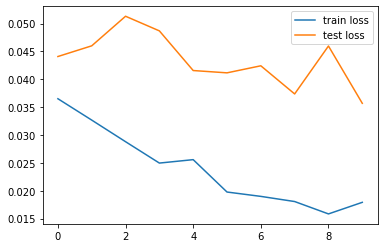

In [17]:
# plotting the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

plt.show()

In [32]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # forward pass
  outputs = model(inputs)

  # Predict using torch.max for max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  
  n_correct +=(predictions  == targets).sum().item()
  n_total += targets.shape[0]

  train_acc = n_correct / n_total

  # Repeat for test
  n_correct = 0.
  n_total = 0.
  for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    # Predict using torch.max for max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9896, Test acc: 0.9895
